<a href="https://colab.research.google.com/github/robinjacobroy/tree_counting/blob/main/Tree_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1WfqjG1UrpjecnegkkCy6WL8nKU1hGiJb
!tar -xzf imagesNmasks.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1WfqjG1UrpjecnegkkCy6WL8nKU1hGiJb
To: /content/imagesNmasks.tar.gz
100% 442M/442M [00:10<00:00, 42.8MB/s]


In [ ]:
##the 10k x 10k images were cropped to 2048 x 2048 patches using the
##below given code.

In [ ]:
#@title
#Cropping the 10k x 10k images and masks into 2048x2048 patches
#!rm -rf rgb masks
!mkdir rgb masks

from PIL import Image
from itertools import product
import os
from tqdm import tqdm

def crop_ims(fln):
  img = Image.open(f"./BigPic_crops/{fln}")
  mask = Image.open(f"./GT_binary/{fln}")
  w, h = img.size
  d = 2048
  name = fln.rpartition(".png")[0]
  dir_rgb = "rgb"
  dir_mask = "masks"
  grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
  for i, j in grid:
    box = (j, i, j+d, i+d)
    out1 = os.path.join(dir_rgb, f'{name}_{i}_{j}.png')
    img.crop(box).save(out1)
    out2 = os.path.join(dir_mask, f'{name}_{i}_{j}.png')
    mask.crop(box).save(out2)

for fln in tqdm(os.listdir("./GT_binary/")):
  crop_ims(fln)

In [ ]:
#the hidden cell below uses albumentations library to augment images
#and save them into a new folder

In [ ]:
#@title
!mkdir -p augmented_ims/{images,masks}

import os
import cv2
from tqdm import tqdm
from glob import glob
from albumentations import RandomRotate90, HorizontalFlip, VerticalFlip

def load_data(path):
     images = sorted(glob("rgb/*.png"))
     masks = sorted(glob('masks/*.png'))
     return images, masks

def augment_data(images, masks, save_path, augment=True):

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)


        aug = RandomRotate90(p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented['image']
        y1 = augmented['mask']

        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']

        save_images = [x, x1, x2, x3]
        save_masks =  [y, y1, y2, y3]


        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):

            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1


imgs, msks = load_data("./")
augment_data(imgs, msks, "augmented_ims")

In [ ]:
#total 825 crops were obtained
!ls rgb | wc -l

825


In [ ]:
#import necessary packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
import random

In [ ]:
#Keras Image generator for memory optimization

IMAGE_SIZE = 1024
BATCH_SIZE = 4
NUM_CLASSES = 2
DATA_DIR = "./"
NUM_TRAIN_IMAGES = 650
NUM_VAL_IMAGES = 150
NUM_TEST_IMAGES = 25

images = glob(os.path.join(DATA_DIR, "rgb/*"))
masks = glob(os.path.join(DATA_DIR, "masks/*"))
temp = list(zip(images, masks))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
res1, res2 = list(res1), list(res2)


train_images = res1[:NUM_TRAIN_IMAGES]
train_masks = res2[:NUM_TRAIN_IMAGES]
val_images = res1[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = res2[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]

test_images = res1[
    NUM_VAL_IMAGES + NUM_TRAIN_IMAGES:
]
test_masks = res2[
    NUM_VAL_IMAGES + NUM_TRAIN_IMAGES:
]
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.io.decode_image(image, channels=1)
        image.set_shape([None, None, 1])

        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
        image = tf.cast(image, tf.float32) / 255.0
    else:
        image = tf.io.decode_png(image, channels=3)

        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.float32) / 255.0
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomBrightness(factor=(-1,1))
    self.augment_labels = tf.keras.layers.RandomBrightness(factor=(-1,1))
    #self.augment_inputs1 = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    #self.augment_labels1 = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    #self.augment_inputs2 = tf.keras.layers.RandomRotation(.5, seed=seed)
    #self.augment_labels2 = tf.keras.layers.RandomRotation(.5, seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    #inputs = self.augment_inputs2(inputs)
    #labels = self.augment_labels2(labels)
    return inputs, labels

def data_generator_aug(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(Augment())
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


######################################################################
#train_dataset = data_generator(train_images, train_masks)
train_dataset = data_generator_aug(train_images, train_masks)

val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

In [ ]:
!mkdir tfrec_aug

tf.data.experimental.save(
    train_dataset, "./tfrec_aug")

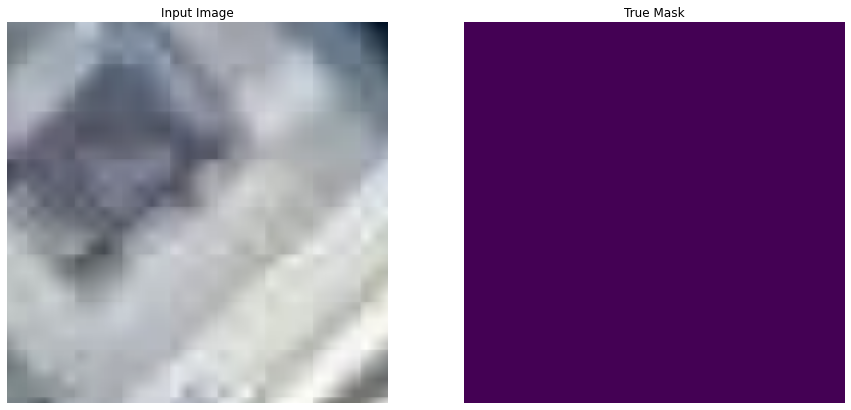

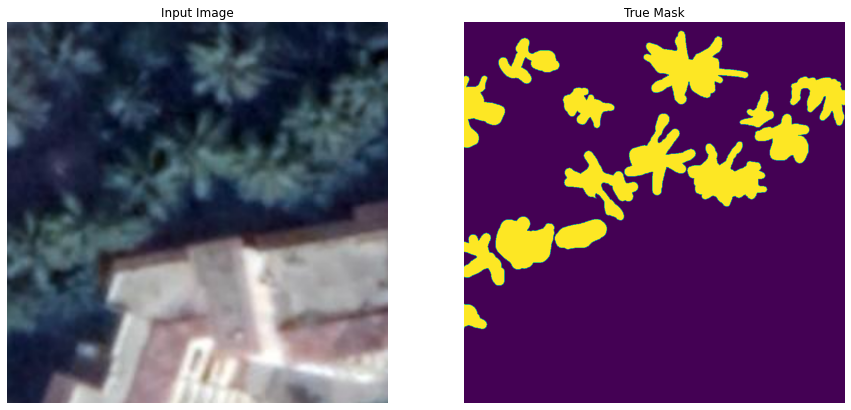

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

################################################################
def multi_unet_model(n_classes=1, IMG_HEIGHT=1024, IMG_WIDTH=1024, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model



########################################################################

def get_model():
    return multi_unet_model()

model = get_model()
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 dropout (Dropout)              (None, 1024, 1024,   0           ['conv2d[0][0]']                 
                                16)                                                           

In [ ]:
es = [
        keras.callbacks.EarlyStopping(

        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        mode = 'max',
        # "no longer improving" being further defined as "for at least 5 epochs"
        patience=5,
        verbose=1,
    )
]
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_dataset, validation_data=val_dataset, \
                    epochs=25,verbose=1, callbacks=[es,mc], shuffle=False)

Epoch 1/25
162/162 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.8080
Epoch 1: val_accuracy improved from -inf to 0.83877, saving model to best_model.h5
162/162 [==============================] - 141s 748ms/step - loss: 0.3981 - accuracy: 0.8080 - val_loss: 0.3351 - val_accuracy: 0.8388
Epoch 2/25
162/162 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8380
Epoch 2: val_accuracy improved from 0.83877 to 0.84461, saving model to best_model.h5
162/162 [==============================] - 124s 758ms/step - loss: 0.3299 - accuracy: 0.8380 - val_loss: 0.3145 - val_accuracy: 0.8446
Epoch 3/25
162/162 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8451
Epoch 3: val_accuracy improved from 0.84461 to 0.85199, saving model to best_model.h5
162/162 [==============================] - 124s 761ms/step - loss: 0.3185 - accuracy: 0.8451 - val_loss: 0.3062 - val_accuracy: 0.8520
Epoch 4/25
162/162 [==============================] 

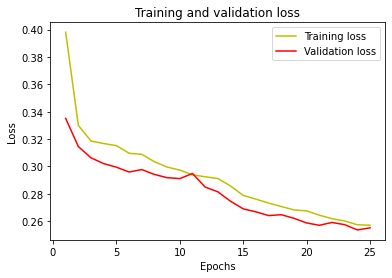

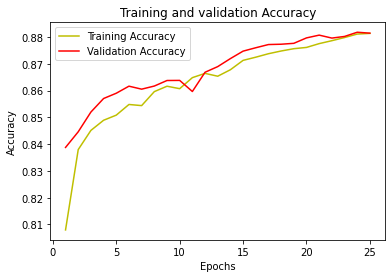

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load previously saved model
#loaded_model = tf.keras.models.load_model('best_model.h5')
#model.load_weights("best_model.h5")

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(test_dataset, verbose=2)
print("Model accuracy on test data: {:5.2f}%".format(100 * acc))

#Predict on unseen test data
y_pred = model.predict(test_dataset, batch_size = 4, verbose=2)

test_list = list(test_dataset.as_numpy_iterator())
y = [test_list[i][1][j] for i in range(len(test_list)) for j in range(len(test_list[0][0]))]

#IOU
y_pred_thresholded = y_pred > 0.4
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_pred_thresholded, y)
print("Mean IoU =", IOU_keras.result().numpy())

6/6 - 3s - loss: 0.2476 - accuracy: 0.8830 - 3s/epoch - 521ms/step
Model accuracy on test data: 88.30%
6/6 - 3s - 3s/epoch - 537ms/step
Mean IoU = 0.68808836


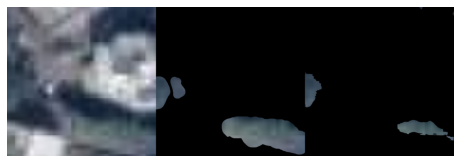

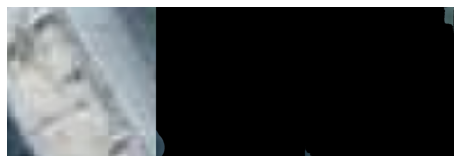

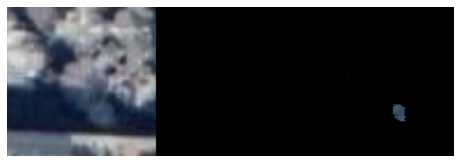

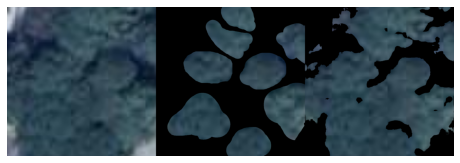

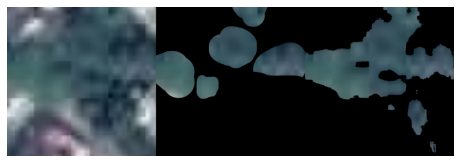

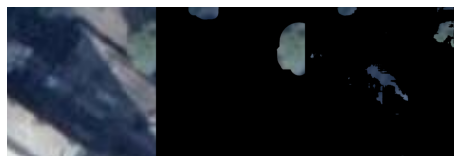

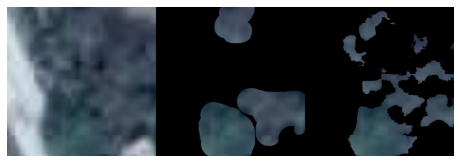

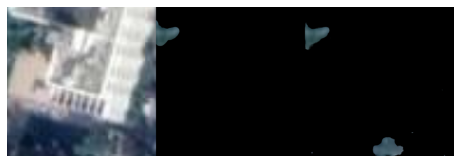

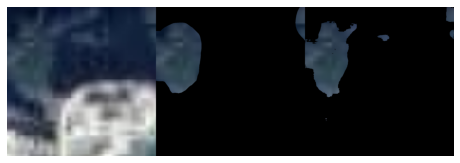

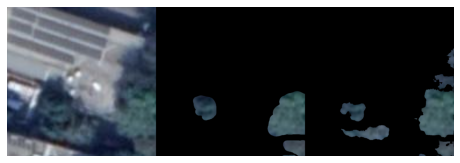

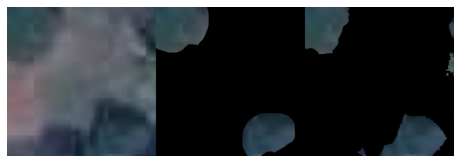

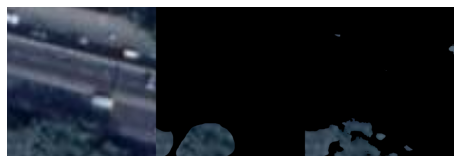

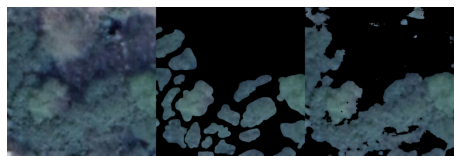

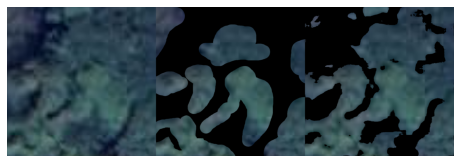

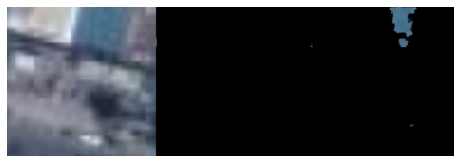

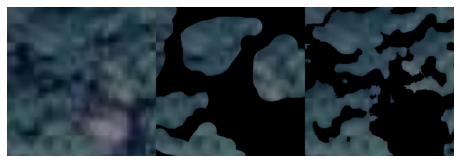

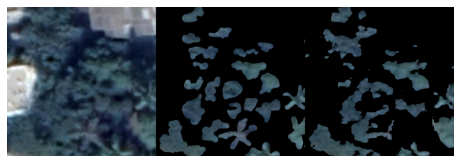

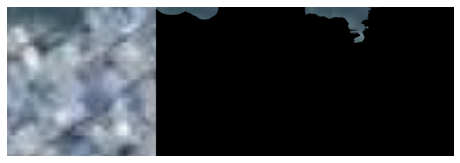

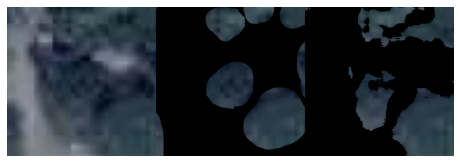

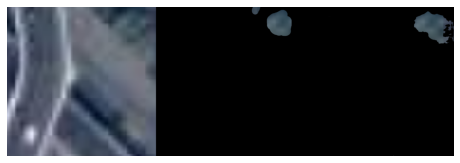

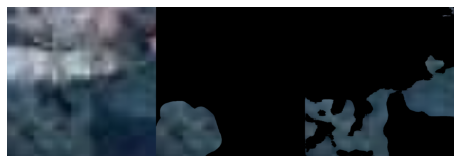

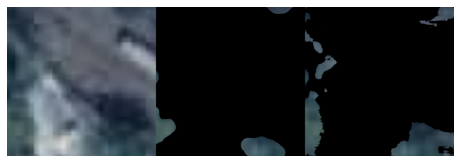

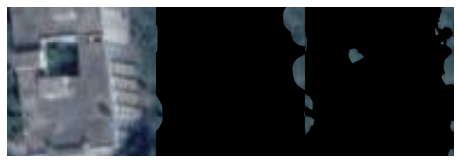

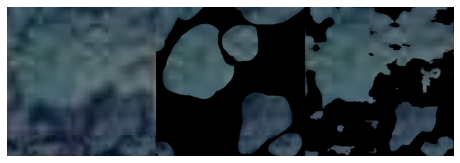

In [ ]:
#Display the test image, its label and model prediction side by side
x = [test_list[i][0][j] for i in range(len(test_list)) for j in range(len(test_list[0][0]))]
for i in range(len(x)):
  plt.figure(figsize=(8,5))
  plt.axis("off")
  msk = np.dstack((y_pred_thresholded[i,...,0], )*3 )
  msk_orig = np.dstack((y[i][...,0],)*3)
  plt.imshow(np.hstack((x[i], x[i]*msk_orig, x[i]*msk)))
  plt.show()